<a href="https://colab.research.google.com/github/sarikasea/Machine-Learning/blob/main/Multi_class_Classification_Obesity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing ibraries and Data

In [1]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"
data = pd.read_csv(file_path)
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Exploratory Data Analysis

Visualize the distribution of the target variable to understand the class balance.


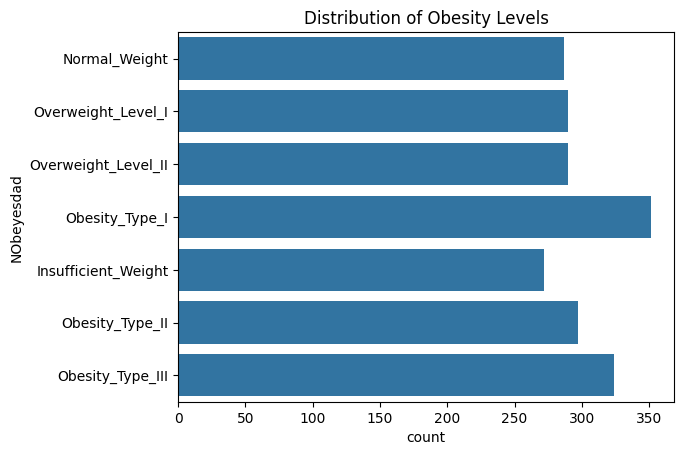

In [4]:
# Distribution of target variable
sns.countplot(y='NObeyesdad', data=data)
plt.title('Distribution of Obesity Levels')
plt.show()

This shows that the dataset is fairly balanced and does not require any special attention in terms of biased training.


### Exercise 1
Check for null values, and display a summary of the dataset (use `.info()` and `.describe()` methods).


In [5]:
# Checking for null values
print(data.isnull().sum())

# Dataset summary
print(data.info())
print(data.describe())

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height             

Expected Output:

* Counts of null values for each column (likely zero for this dataset).
* Dataset info including column names, data types, and memory usage.
* Descriptive statistics for numerical columns.


## Preprocessing the data


### Feature scaling
Scale the numerical features to standardize their ranges for better model performance.

Feature scaling is a technique used in data preprocessing to standardize or normalize the range of independent variables or features of a dataset. This is done to ensure that all features contribute equally to the outcome, especially in algorithms that are sensitive to the magnitude of the features (e.g., gradient descent-based algorithms, distance-based algorithms like K-Nearest Neighbors and Support Vector Machines).

There are two common types of feature scaling:

Standardization (Z-score normalization): This method scales the features such that they have a mean of 0 and a standard deviation of 1. It is calculated as: $X_{scaled} = (X - mean(X)) / std(X)$$X_{scaled} = (X - mean(X)) / std(X)$
Normalization (Min-Max scaling): This method scales the features to a fixed range, usually between 0 and 1. It is calculated as: $X_{scaled} = (X - min(X)) / (max(X) - min(X))$$X_{scaled} = (X - min(X)) / (max(X) - min(X))$
Feature scaling helps to prevent features with larger values from dominating the learning process and ensures that the model converges faster and performs better.

In [6]:
# Standardizing continuous numerical features
continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[continuous_columns])

# Converting to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(continuous_columns))

# Combining with the original dataset
scaled_data = pd.concat([data.drop(columns=continuous_columns), scaled_df], axis=1)

Standardization of data is important to better define the decision boundaries between classes by making sure that the feature variations are in similar scales. The data is now ready to be used for training and testing.


Standardization of data is important to better define the decision boundaries between classes by making sure that the feature variations are in similar scales. The data is now ready to be used for training and testing.


### One-hot encoding
Convert categorical variables into numerical format using one-hot encoding.


In [7]:
# Identifying categorical columns
categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')  # Exclude target column

# Applying one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

# Converting to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Combining with the original dataset
prepped_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)

In [10]:
prepped_data.head()

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,Normal_Weight,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,Normal_Weight,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,Normal_Weight,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Overweight_Level_I,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Overweight_Level_II,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


You will observe that all the categorical variables have now been modified to one-hot encoded features. This increases the overall number of fields to 24.

### Encode the target variable


In [11]:
# Encoding the target variable
prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes
prepped_data.head()

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Separate the input and target data


In [12]:
# Preparing final dataset
X = prepped_data.drop('NObeyesdad', axis=1)
y = prepped_data['NObeyesdad']

## Model training and evaluation


### Splitting the data set
Split the data into training and testing subsets.


In [13]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Logistic Regression with One-vs-All
In the One-vs-All approach:

* The algorithm trains a single binary classifier for each class.
* Each classifier learns to distinguish a single class from all the others combined.
* If there are k classes, k classifiers are trained.
* During prediction, the algorithm evaluates all classifiers on each input, and selects the class with the highest confidence score as the predicted class.

#### Advantages:
* Simpler and more efficient in terms of the number of classifiers (k)
* Easier to implement for algorithms that naturally provide confidence scores (e.g., logistic regression, SVM).

#### Disadvantages:
* Classifiers may struggle with class imbalance since each binary classifier must distinguish between one class and the rest.
* Requires the classifier to perform well even with highly imbalanced datasets, as the "all" group typically contains more samples than the "one" class.


Train a logistic regression model using the One-vs-All strategy and evaluate its performance.


In [14]:
# Training logistic regression model using One-vs-All (default)
model_ova = LogisticRegression(multi_class='ovr', max_iter=1000)
model_ova.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr')

You can now evaluate the accuracy of the trained model as a measure of its performance on unseen testing data.


In [15]:
# Predictions
y_pred_ova = model_ova.predict(X_test)

# Evaluation metrics for OvA
print("One-vs-All (OvA) Strategy")
print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ova),2)}%")

One-vs-All (OvA) Strategy
Accuracy: 76.12%


### Logistic Regression with OvO

In the One-vs-One approach:
* The algorithm trains a binary classifier for every pair of classes in the dataset.
* If there are k classes, this results in $k(k-1)/2$ classifiers.
* Each classifier is trained to distinguish between two specific classes, ignoring the rest.
* During prediction, all classifiers are used, and a "voting" mechanism decides the final class by selecting the class that wins the majority of pairwise comparisons.

#### Advantages:
* Suitable for algorithms that are computationally expensive to train on many samples because each binary classifier deals with a smaller dataset (only samples from two classes).
* Can be more accurate in some cases since classifiers focus on distinguishing between two specific classes at a time.

#### Disadvantages:
* Computationally expensive for datasets with a large number of classes due to the large number of classifiers required.
* May lead to ambiguous predictions if voting results in a tie.


Train a logistic regression model using the One-vs-One (OvO) strategy and evaluate its performance.


In [16]:
# Training logistic regression model using One-vs-One
model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
model_ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression(max_iter=1000))

Evaluate the accuracy of the trained model as a measure of its performance on unseen testing data.


In [ ]:
# Predictions
y_pred_ovo = model_ovo.predict(X_test)

# Evaluation metrics for OvO
print("One-vs-One (OvO) Strategy")
print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ovo),2)}%")

## Exercises


Q1. Experiment with different test sizes in the train_test_split method (e.g., 0.1, 0.3) and observe the impact on model performance.


In [18]:
for test_size in [0.2, 0.5]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    model_ova.fit(X_train, y_train)
    y_pred = model_ova.predict(X_test)
    print(f"Test Size: {test_size}")
    print("Accuracy:", accuracy_score(y_test, y_pred))

Test Size: 0.2
Accuracy: 0.7612293144208038
Test Size: 0.5
Accuracy: 0.771780303030303


Q2. Plot a bar chart of feature importance using the coefficients from the One vs All logistic regression model. Also try for the One vs One model.


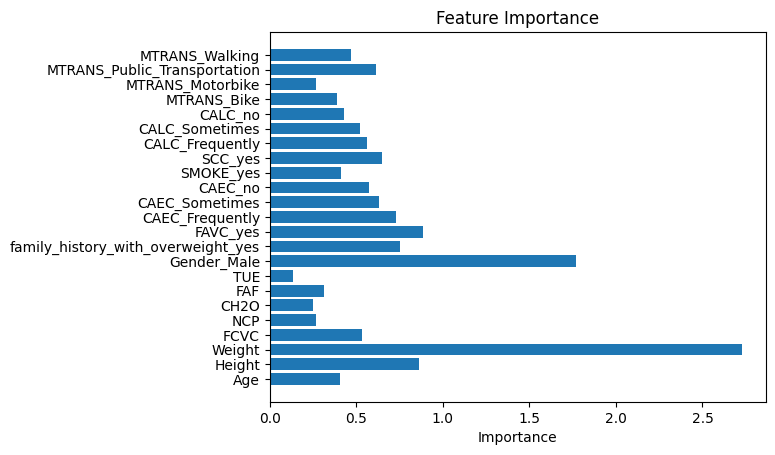

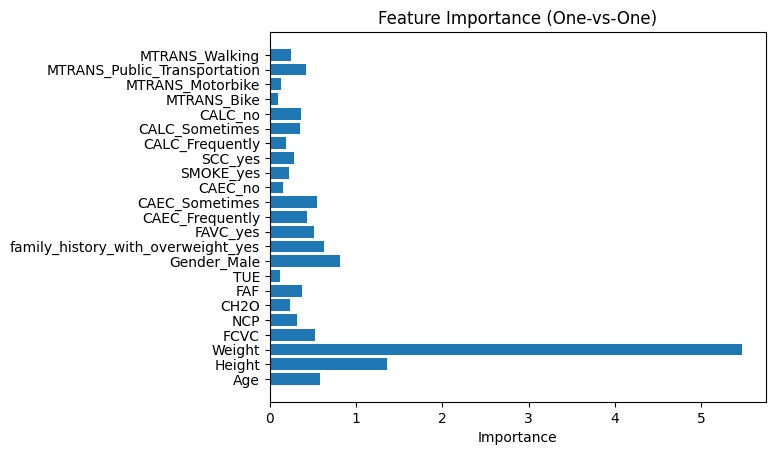

In [19]:
feature_importance = np.mean(np.abs(model_ova.coef_), axis=0)
plt.barh(X.columns, feature_importance)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

# For One vs One model
# Collect all coefficients from each underlying binary classifier
coefs = np.array([est.coef_[0] for est in model_ovo.estimators_])

# Now take the mean across all those classifiers
feature_importance = np.mean(np.abs(coefs), axis=0)

# Plot feature importance
plt.barh(X.columns, feature_importance)
plt.title("Feature Importance (One-vs-One)")
plt.xlabel("Importance")
plt.show()

Q3. Write a function `obesity_risk_pipeline` to automate the entire pipeline: <br>
<ol>
<li> Loading and preprocessing the data </li>
<li> Training the model </li>
<li> Evaluating the model </li>
</ol>
The function should accept the file path and test set size as the input arguments.


In [20]:
def obesity_risk_pipeline(data_path, test_size=0.2):
    # Load data
    data = pd.read_csv(data_path)

    # Standardizing continuous numerical features
    continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[continuous_columns])

    # Converting to a DataFrame
    scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(continuous_columns))

    # Combining with the original dataset
    scaled_data = pd.concat([data.drop(columns=continuous_columns), scaled_df], axis=1)

    # Identifying categorical columns
    categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
    categorical_columns.remove('NObeyesdad')  # Exclude target column

    # Applying one-hot encoding
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

    # Converting to a DataFrame
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

    # Combining with the original dataset
    prepped_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)

    # Encoding the target variable
    prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes

    # Preparing final dataset
    X = prepped_data.drop('NObeyesdad', axis=1)
    y = prepped_data['NObeyesdad']

    # Splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Training and evaluation
    model = LogisticRegression(multi_class='multinomial', max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))

# Call the pipeline function with file_path
obesity_risk_pipeline(file_path, test_size=0.2)

Accuracy: 0.8794326241134752
